In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sin, cos, atan2, sqrt, pi, radians
import statsmodels.api as sm

%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 1. Load data

### Load Bridge Data

In [3]:
df_bridge = pd.read_excel("BMMS_overview_original.xlsx")
road_num = df_bridge["road"].unique()
df_bridge = pd.DataFrame(data = [[road, df_bridge[df_bridge["road"] == road]] for road in road_num],
                       columns=['road', 'data_frame'])
df_bridge.head()

,road,data_frame
0,N1,road km type LR...
1,N2,road km type LRPN...
2,N3,road km type LR...
3,N4,road km type LR...
4,N5,road km type LR...


### Load Road Data

In [4]:
df_road = pd.read_csv("_roads2.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road, df_road[df_road['road'] == road]] for road in road_num],
                       columns=['road', 'data_frame'])
df_road.head()

,road,data_frame
0,N1,road chainage lrp lat ...
1,N101,road chainage lrp lat ...
2,N102,road chainage lrp lat ...
3,N103,road chainage lrp lat ...
4,N104,road chainage lrp lat ...


In [5]:
# Select the road: N1
df_r = df_road['data_frame'].iloc[0]
df_r.head(3)

,road,chainage,lrp,lat,lon,type,name
0,N1,0.000,LRPS,23.706028,90.443333,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,CrossRoad,Intersection with Z1101


### Sorting out Duplicates of bridges

1. Fill out NA value with a value which has a same 'chainage' value. (In order to prevent losing information at the next step.)
2. Drop out data points if they have a same 'chainage' value.
3. In order to locate the recent information at upper side, reverse the order before the implementation
    - It is assumable that the more recent data are recored on the lower line. Therefore, reversing the order will let the data to keep the most recent information.

In [6]:
df_b = df_bridge['data_frame'].iloc[0]

#### 1. Fill NA value

In [7]:
# identify all rows where duplicates exist
df_b["dup1"] = df_b.duplicated("km", keep="last")
df_b["dup2"] = df_b.duplicated("km", keep="first")
df_b = df_b.sort_values('km')
df_b["dup3"] = df_b["dup1"] | df_b["dup2"]
df_dup = df_b[df_b["dup3"]]
df_dup.head()

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,zone,circle,division,sub-division,lat,lon,EstimatedLoc,dup1,dup2,dup3
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,...,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise,True,False,True
13420,N1,8.976,PC Girder Bridge,LRP008b,KANCHPUR PC GIRDER BRIDGE,397.00,C,101102,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,...,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702083,90.515917,bcs1,False,True,True
10,N1,12.660,PC Girder Bridge,LRP013a,MADANPUR BRIDGE(L),26.30,A,109838,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,12.66,...,Dhaka,Dhaka,Narayanganj,Vitikandi,23.691111,90.544889,bcs1,False,True,True
9,N1,12.660,PC Girder Bridge,LRP013a,MADAN PUR (R),26.30,A,109841,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,12.66,...,Dhaka,Dhaka,Narayanganj,Vitikandi,23.691111,90.544889,bcs1,True,True,True
8,N1,12.660,PC Girder Bridge,LRP013a,Madanpur Bridge.(L),27.50,A,119897,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,12.66,...,Dhaka,Dhaka,Narayanganj,Vitikandi,23.685500,90.551278,road_precise,True,False,True


#### 2. Visualize missing values

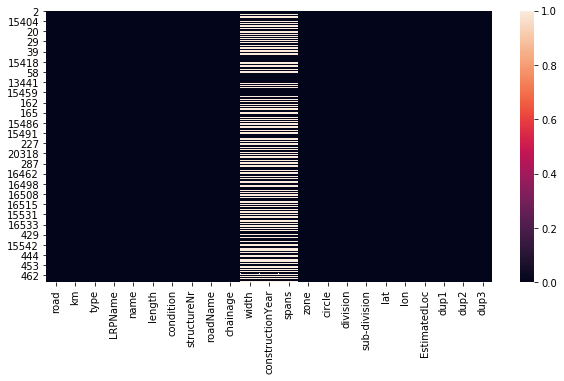

In [8]:
plt.figure(figsize = (10,5))
sns.heatmap(df_dup.isnull())
# width, construction year, spans are missing

In [9]:
# fill out
new_df = pd.DataFrame()
for i in range(len(df_dup["km"].unique())):
    df = df_dup[df_dup["km"] == df_dup["km"].unique()[i]]
    df.fillna(method = "ffill", inplace = True)
    df.fillna(method = "bfill", inplace = True)
    new_df = pd.concat([new_df, df])
df_dup = new_df

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


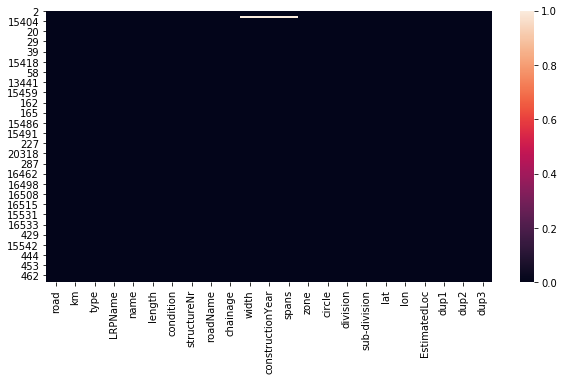

In [10]:
# visualize again
plt.figure(figsize = (10,5))
sns.heatmap(df_dup.isnull())
# NA value has filled out, unless there is no data point from the first place.

## 2. Visual Check
#### Plot the bridges align to its corresponding road (as all bridges are basically supposed to be on the road!)

1. How far bridges deviates from its corresponding road.
2. How far bridges deviates from its own trend. (Only if the corresponding road data is missing.)

#### Again, longitude and latitude elements are decomposed

### Key Algorithm(!)
#### How to detect? Outlier is detected when:
- the location of bridge deviates from the (estimated) true location (on the road) more than 10% of the entire range of coordinates.

#### For example,
1. when the entire latitudes data spread from 21.0 through 23.0, the entire range is 2.0
2. In this case, if the change between two coordinates is larger than 0.2 (10%), it is considered as an outlier.

In [11]:
def visual_check(df_b, df_r, rank = 3, bar = 0.1, cols = ["lat", "lon"], names = ["Latitude", "Longitude"], hide_road = False, pr = True):
    """
    This function is a visualization tool.
    1. Visualize all roads align to its road belongs.
    2. Check outliers (Further explanation is described below.)
    3. Decompose the latitude and longtitude vectors
    """
    
#     by using "chainage", estimated the true location of bridges
    df = pd.DataFrame()
    for i in range(len(df_b)):
        df_b["chainage"].iloc[i]
        idx = abs(df_r["chainage"] - df_b["chainage"].iloc[i]).sort_values().head(1).index
        df = pd.concat([df, df_r[["lat", "lon"]].loc[idx]])

    loc_r = df_r[["lat", "lon"]]
    loc_b = df_b.sort_values("km")[["lat", "lon"]]
    loc_b_est = df[["lat", "lon"]]

#     start plotting
    plt.figure(figsize = (15,7))
    for i in range(len(cols)):
        plt.subplot(1,2,i+1)

#         plot the road as a reference
        if not hide_road:
            plt.plot(loc_r["lat"], loc_r["lon"], color = "green", ls = "-", lw = 10, alpha = 0.4,
                        label = "Road (true location of bridges)")

#         plot all bridges
        plt.scatter(loc_b["lat"], loc_b["lon"], color = "green",
                    label = "Bridge")

#         decompose lat and lon components
        xy = []
        xyest = []

        x = np.linspace(min(loc_b[cols[1-i]]), max(loc_b[cols[1-i]]), len(df_b))
        y = loc_b[cols[i]].reset_index(drop = True)

        xy.append(x)
        xy.append(y)
        xyest.append(x)
        yest = loc_b_est[cols[i]]
        xyest.append(yest)

#         plot (estimated) true location
        plt.plot(xyest[1-i], xyest[i], color = "blue", alpha = 0.3, lw = 10,
                 label = "Trend of bridge data")

#         plot (decomposed) coordinates of bridge
        plt.plot(xy[1-i], xy[i], color = "red",
                 label = "Decomposed {name}".format(name = names[i]))

#         identify outliers
        """
        <Key Algorithm(!)>
        How to detect?
        Outlier is detected when:
        - the location of bridge deviates from the (estimated) true location more than 10% (defalut) of the entire range of coordinates.        
        - For example, when the whole latitude changes spread from 21 through 23, the entire length is 2.
        - In this case, if the change between two coordinates is larger than 0.2, it is considered as an outlier.
        """
    
        rng = max(yest) - min(yest)
        out = np.where(abs(np.array(yest) - y)/rng > bar)
        
#         plot outliers
        plt.scatter(loc_b["lat"].iloc[out], loc_b["lon"].iloc[out], marker = "+", s = 300, color = "red",
                    label = "{name} outlier (>{perc}% dev.)".format(name = names[i], perc = bar * 100))        

#         plot suspicious points by rank
#         : regardless of the existence of outliers, always show the top 5 deviations
        top = (abs(np.array(yest) - y)/rng).sort_values(ascending = False).index[:rank]
        plt.scatter(xy[1-i][top], xy[i][top], marker = "o", s = 100, facecolors = "none", edgecolors = "blue", linewidths = 2,
                    label = "Suspicious (top {rank})".format(rank = rank))
#         print the outliers
        if pr:
            print("<List of Outliers from {name}>".format(name = names[i]), "\n", df_b.iloc[out][["chainage", "LRPName", "lat", "lon"]])
            print("\n")

        plt.xlabel("Latitude", size = 14)
        plt.ylabel("Longitude", size = 14)
        plt.title("{name} Decomposition".format(name = names[i]), size = 20)
        plt.grid()
        plt.legend(fontsize = "large")

<List of Outliers from Latitude> 
       chainage  LRPName        lat        lon
15468  209.514  LRP212a  23.550333  91.690222
334    385.237  LRP381c  22.409639  92.052556
336     385.78  LRP382b  22.406944  92.056889


<List of Outliers from Longitude> 
       chainage  LRPName        lat        lon
16553  459.866  LRP456b  20.867278  90.298389




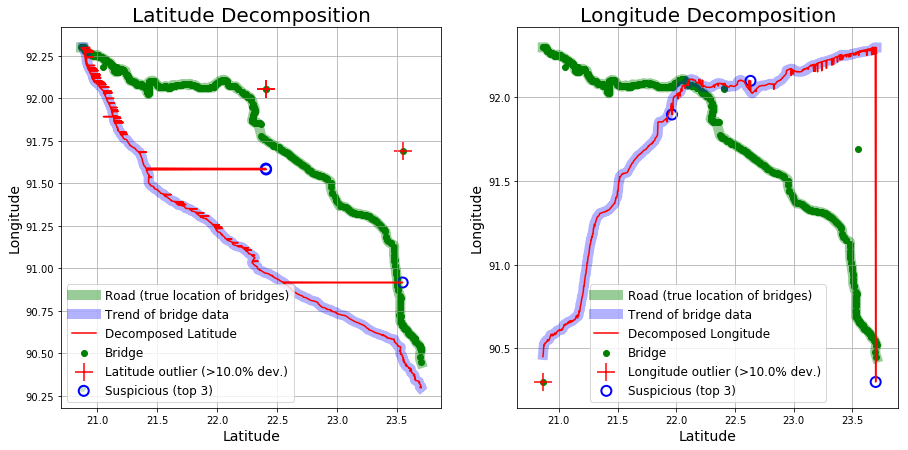

In [12]:
visual_check(df_b, df_r)

### Interpretation of above graphs
#### 4 outliers are detected. (Red cross mark)
- 3 come from latitude
- 1 comes from lontitude

## 3. Correcting the location
### The algorithm is : Use chainage as a 'key' between road and bridge. The detail is as following:
- Check the 'chainage' of outlier
- Search for the road data, and find out the two closest road data which has the same chainage value
- Correct outlier's location on the road

#### For example, if the chainage of the outlier is 15km and the chainage of the roads are 14.2, <u>14.5, 15.3</u>, 16.1km:
- Select the closest data points of the road (<u>14.5km, 15.3km</u>).
- Refer to the coordinates of two points and calculate the mean value.
- Switch the outlier's coordinates into this value.

In [13]:
def fix_bridges(df_b, df_r, nbr = 20, rank = 3, bar = 0.01, cols = ["lat", "lon"], names = ["Latitude", "Longitude"]):
    """
    This function fixes the location of the bridges, based on the road where they belong to.
    1. Detect outliers
    2. Force the wrong coordinates to change into the (estimated) true location 
    """
    # road data
    loc_r = df_r[["lat", "lon"]]
    
    # bridge data
    loc_b = df_b.sort_values("km")[["lat", "lon"]]
    
    # create the data frame of the road, which will be used to estimate the true location of wrong bridges
    df = pd.DataFrame()
    for i in range(len(df_b)):
        df_b["chainage"].iloc[i]
        idx = abs(df_r["chainage"] - df_b["chainage"].iloc[i]).sort_values().head(1).index
        df = pd.concat([df, df_r[["lat", "lon"]].loc[idx]])
    loc_b_est = df[["lat", "lon"]]
    
    for i in range(len(cols)): 
        y = loc_b[cols[i]].reset_index(drop = True)
        yest = loc_b_est[cols[i]]
        
        """
        The fixing algorithm is basically: Use chainage as a 'key.' The detail is as following:
        - Check the 'chainage' of outlier
        - Search for the road data, and find out the two closest road data with the value of the chainage.
        - For example:
            If the chainage of the outlier is 15km and the chainage of the roads are 14.2, 14.5, 15.3, 16.1km,
            then select the data points of (14.5km, 15.3km).
            After, refer to the coordinates of two data points and calculate the mean value.
            Switch the outlier's coordinates into the value.
        """

#         identify outliers
        rng = max(yest) - min(yest)
        out = np.where(abs(np.array(yest) - y)/rng > bar)
    
#         fit outliers to the (estimated) true location
        idx = y[abs(np.array(yest) - y)/rng > bar].index
        fix_vals = []
        for j in range(len(df_b.iloc[out])):
            err_vals_ch = np.array(df_b.iloc[out]["chainage"])
            ref_road1 = df_r[df_r["chainage"] > err_vals_ch[j]].head(1)[cols[i]].values
            ref_road2 = df_r[df_r["chainage"] < err_vals_ch[j]].tail(1)[cols[i]].values
            fix_val = np.mean([ref_road1, ref_road2])
            fix_vals.append(fix_val)
        d = dict(zip(idx, fix_vals))
        
#         drop the coordinates info of outliers
        y = y.where(abs(np.array(yest) - y)/rng <= bar)
    
#         fill the values
        y.fillna(d, inplace = True)
        
        df_b[cols[i]] = y.values
        
    return df_b

### Fix the locations and plot again!

<List of Outliers from Latitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []


<List of Outliers from Longitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []




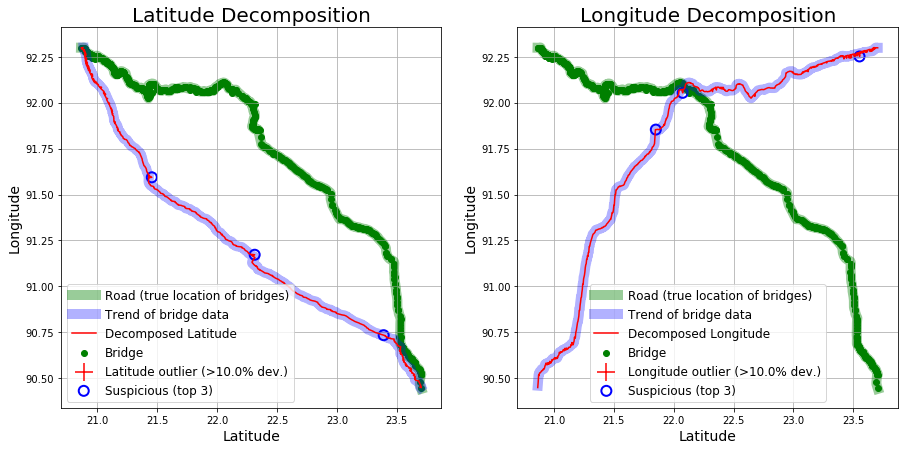

In [14]:
df_b = fix_bridges(df_b, df_r)
visual_check(df_b, df_r)

#### All outliers are now on the road

### However, if the corresponding road data is missing (for example, R505), this algorithm cannot incorporate. 
#### Thus, we also need the visualize and fix function when there is no road data. The way of detecting and fixing is same as the previous road data cleaning.

In [15]:
def visual_check2(df_b, nbr = 20, rank = 3, bar = 0.01, cols = ["lat", "lon"], names = ["Latitude", "Longitude"], hide_road = False):
    """
    Algorithm for detecting outlier, when there is no road.
    """
    loc_b = df_b.sort_values("km")[["lat", "lon"]]

    frac = nbr/len(df_b)
    plt.figure(figsize = (15,7))
    for i in range(len(cols)):    
        plt.subplot(1,2,i+1)
        plt.scatter(loc_b["lat"], loc_b["lon"], color = "green",
                    label = "Bridge")

#         decompose lat and lon components
        xy = []
        xyest = []
        
        predictor = loc_b[cols[1-i]]
        predicted = loc_b[cols[i]]

        x = np.linspace(min(predictor), max(predictor), len(df_b))
        y = predicted.reset_index(drop = True)

        xy.append(x)
        xyest.append(x)
        xy.append(y)
        
#         estimate the trend line
        lowess = sm.nonparametric.lowess(y, x, frac)
        yest = list(zip(*lowess))[1]
        xyest.append(yest)
        
#         plot trend vs. data
        plt.plot(xyest[1-i], xyest[i], color = "blue", alpha = 0.3, lw = 10,
                 label = "(Estimated) trend")
        plt.plot(xy[1-i], xy[i], color = "red",
                 label = "Decomposed {name}".format(name = names[i]))
    
#         plot suspicious points by rank
        top = abs(y/yest - 1).sort_values(ascending = False)[:rank].index
        plt.scatter(xy[1-i][top], xy[i][top], marker = "o", s = 100, facecolors = "none", edgecolors = "blue", linewidths = 2,
                    label = "Suspicious (top {rank})".format(rank = rank))

#         plot outliers
        out = np.where(abs(y/yest - 1) > bar)
        plt.scatter(loc_b["lat"].iloc[out], loc_b["lon"].iloc[out], marker = "+", s = 500, color = "red",
                    label = "{name} outlier (>{perc}% dev.)".format(name = names[i], perc = bar * 100))
        print("<List of Outliers from {name}>".format(name = names[i]), "\n", df_b.iloc[out][["chainage", "LRPName", "lat", "lon"]])
        print("\n")
        plt.xlabel("Latitude", size = 12)
        plt.ylabel("Longitude", size = 12)
        plt.title("{name} Decomposition".format(name = names[i]), size = 25)
        plt.grid()
        plt.legend(fontsize = "large")

In [16]:
def fix_bridges2(df_b, nbr = 20, rank = 3, bar = 0.01, cols = ["lat", "lon"], names = ["Latitude", "Longitude"]):
    """
    worse algorithm for detecting outlier, when there is no road
    """
    loc_b = df_b.sort_values("km")[["lat", "lon"]]
    frac = nbr/len(df_b)
    
    for i in range(len(cols)): 
#         estimate the trend line
        predictor = loc_b[cols[1-i]]
        predicted = loc_b[cols[i]]

        x = np.linspace(min(predictor), max(predictor), len(df_b))
        y = predicted.reset_index(drop = True)

        lowess = sm.nonparametric.lowess(y, x, frac)
        yest = list(zip(*lowess))[1]

#         identify outliers
        out = np.where(abs(y/yest - 1) > bar)

#         fit outliers to yest
        idx = y[abs(y/yest - 1) > bar].index
        new_val = np.array(yest)[out]
        d = dict(zip(idx, new_val))
#         print(d)
        y = y.where(abs(y/yest - 1) <= bar)
#         print(y)
        y.fillna(d, inplace = True)
#         print(y)
        df_b[cols[i]] = y.values
        
    return df_b

### Multiple sample tests for different types of errors

#### Before 1

<List of Outliers from Latitude> 
       chainage  LRPName        lat        lon
15571   69.279  LRP069d  25.056806  90.969583
660    150.812  LRP151b  24.166944  91.533556
675    158.025  LRP159a  24.209694  91.558778
15596  179.044  LRP180a  22.570749  91.602833
855     246.91  LRP247a  25.963389  92.019083
905     284.64  LRP285c  24.900556  91.914167


<List of Outliers from Longitude> 
       chainage  LRPName        lat        lon
20332   75.778  LRP075b  24.037917  90.024278




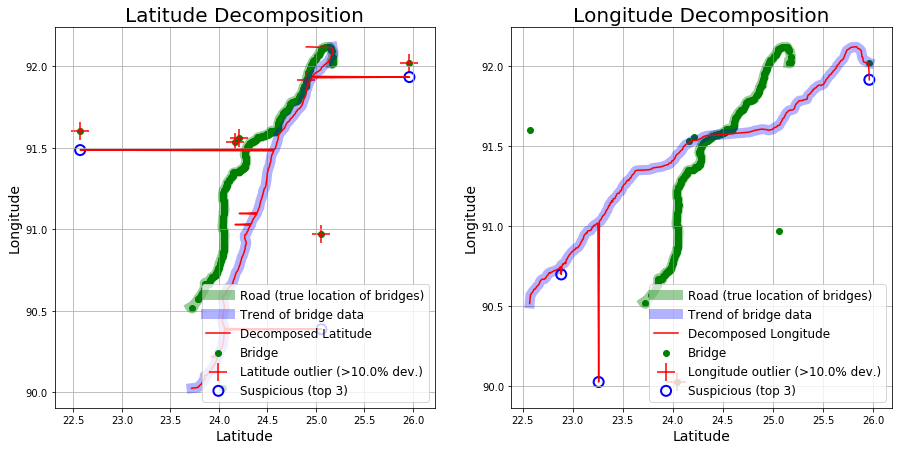

In [17]:
# sampling the road and test
n_road = 1

df_b = df_bridge['data_frame'].iloc[n_road]
df_b = df_b.iloc[::-1]
df_b = df_b.drop_duplicates(subset = ["km"])
df_b = df_b.iloc[::-1]
df_b = df_b.sort_values("km")
df_r = df_road.iloc[np.where(df_road["road"] == df_b["road"].iloc[0])[0][0]]['data_frame']

visual_check(df_b, df_r)

#### After 1

<List of Outliers from Latitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []


<List of Outliers from Longitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []




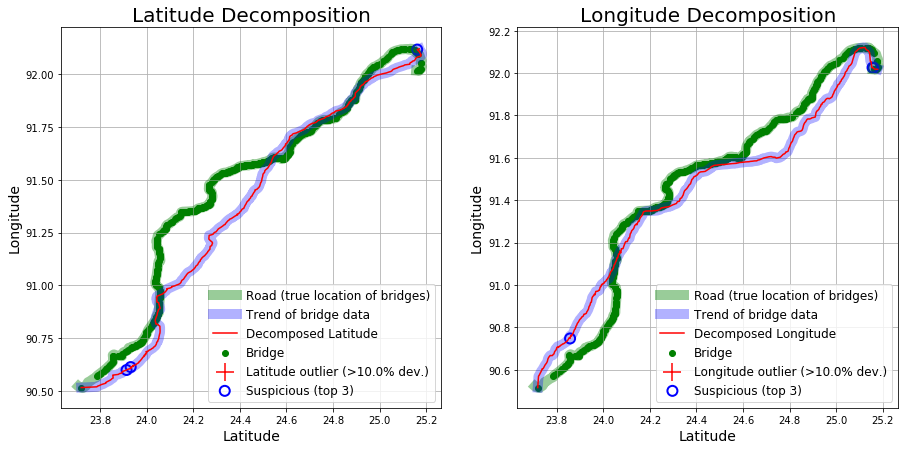

In [18]:
df_b = fix_bridges(df_b, df_r)
visual_check(df_b, df_r)

### Error Case 1: Starting point is wrong

In [19]:
# sampling any roads and test
n_road = 9

df_b = df_bridge['data_frame'].iloc[n_road]
df_b = df_b.iloc[::-1]
df_b = df_b.drop_duplicates(subset = ["km"])
df_b = df_b.iloc[::-1]
df_b = df_b.sort_values("km")
df_r = df_road.iloc[np.where(df_road["road"] == df_b["road"].iloc[0])[0][0]]['data_frame']

<List of Outliers from Latitude> 
      chainage  LRPName        lat        lon
1926    0.349    LRPSa  23.469861  91.162917
1932    17.41  LRP017b  23.941194  91.276472


<List of Outliers from Longitude> 
      chainage LRPName        lat        lon
1926    0.349   LRPSa  23.469861  91.162917




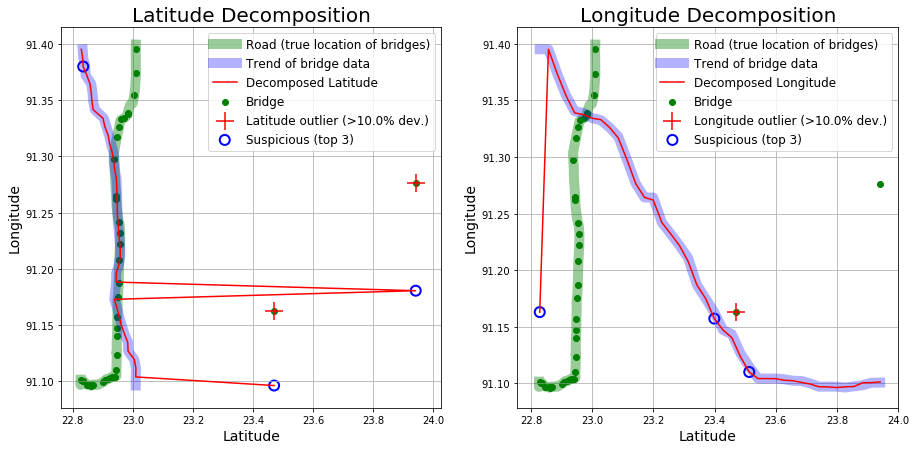

In [20]:
visual_check(df_b, df_r)

<List of Outliers from Latitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []


<List of Outliers from Longitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []




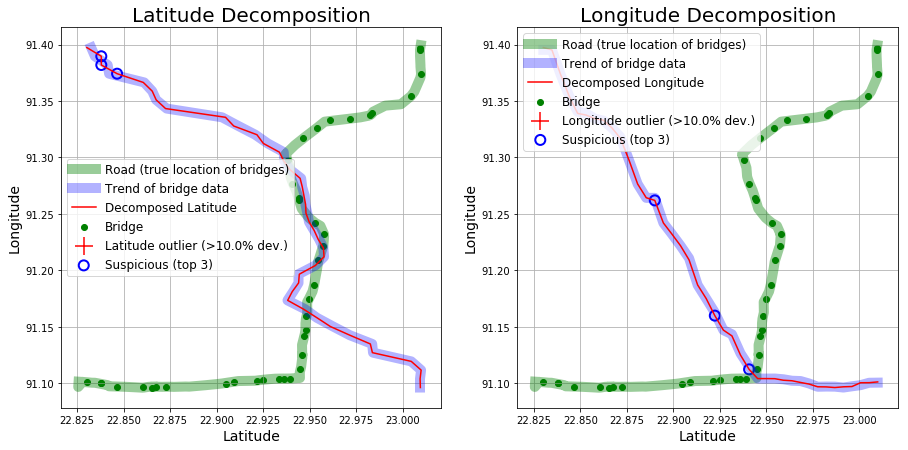

In [21]:
df_b = fix_bridges(df_b, df_r)
visual_check(df_b, df_r)

### Error Case 2: Dozens of data (not a several) are wrong and even some points are totally (both lat, lon) missing

In [22]:
n_road = 35

df_b = df_bridge['data_frame'].iloc[n_road]
df_b = df_b.iloc[::-1]
df_b = df_b.drop_duplicates(subset = ["km"])
df_b = df_b.iloc[::-1]
df_b = df_b.sort_values("km")
df_r = df_road.iloc[np.where(df_road["road"] == df_b["road"].iloc[0])[0][0]]['data_frame']

In [23]:
#drop rows if all values are missing
df_b.dropna(subset=['lat', 'lon'], how='all', inplace = True)

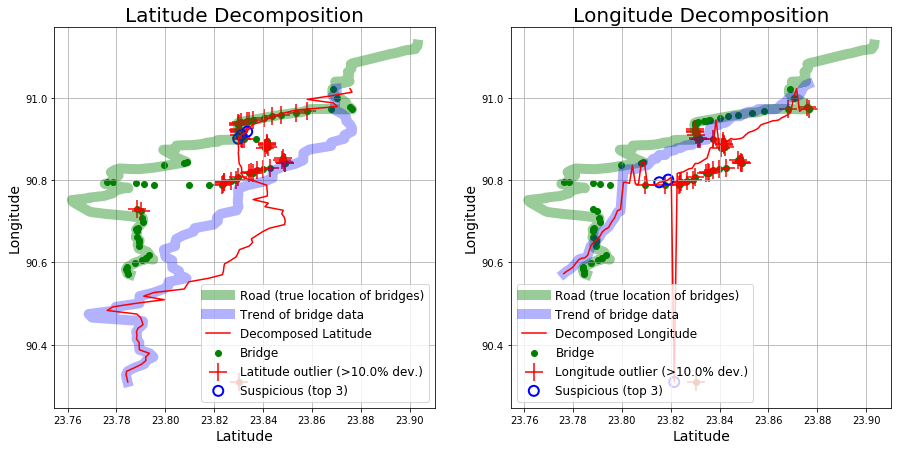

In [24]:
visual_check(df_b, df_r, pr = False)

<List of Outliers from Latitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []


<List of Outliers from Longitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []




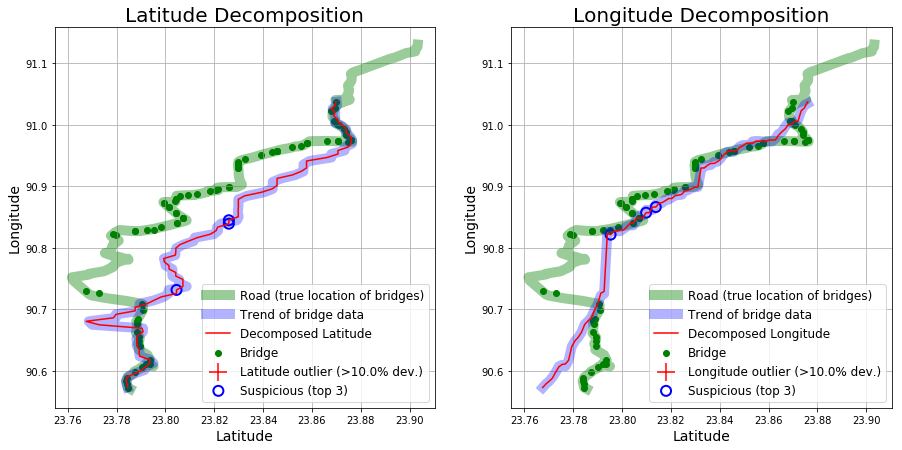

In [25]:
df_b = fix_bridges(df_b, df_r)
visual_check(df_b, df_r)

### Error Case 3: No corresponding road data (R505)

In [26]:
sum(df_road["road"] == "R505")
#no road info R505!!!

0

In [27]:
# sampling any roads and test
n_road = 77

df_b = df_bridge['data_frame'].iloc[n_road]
df_b.dropna(subset=['lat', 'lon'], how='all', inplace = True)
df_b = df_b.iloc[::-1]
df_b = df_b.drop_duplicates(subset = ["km"])
df_b = df_b.iloc[::-1]
df_b = df_b.sort_values("km")

### Since there is no road, use visual_check2() and fix_bridges2()

<List of Outliers from Latitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []


<List of Outliers from Longitude> 
 Empty DataFrame
Columns: [chainage, LRPName, lat, lon]
Index: []




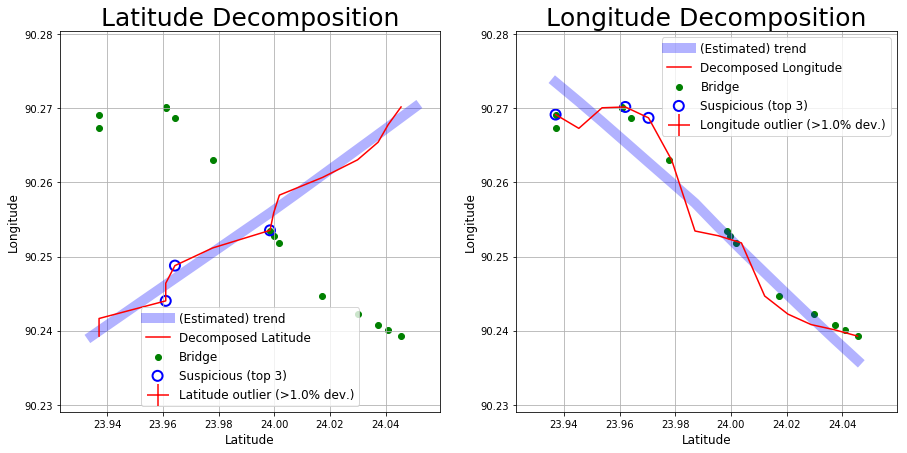

In [28]:
#hide road info
visual_check2(df_b)

In [29]:
#The algorithm does not define outliers in this case, as the trend is more or less moderate.

## 4. Finalize

In [30]:
# load bridges
print("start loading bridges...")
df_bridge = pd.read_excel("BMMS_overview_original.xlsx")
road_num = df_bridge["road"].unique()
df_bridge = pd.DataFrame(data = [[road, df_bridge[df_bridge["road"] == road]] for road in road_num],
                         columns=['road', 'data_frame'])
print("bridges are loaded.")

start loading bridges...
bridges are loaded.


#### Fill out missing values

In [31]:
# drop duplicates
print("start filling out missing values...")
len_2 = len(road_num)
for j in range(len_2):
    if j != 0:
        if j % 50 == 0:
            print(round(j/len_2*100), "% - ", j, "out of", len_2)
    df_b = df_bridge['data_frame'].iloc[j]
    
#     identify all rows where duplicates exist
    df_b["dup1"] = df_b.duplicated("km", keep="last")
    df_b["dup2"] = df_b.duplicated("km", keep="first")
    df_b = df_b.sort_values('km')
    df_b["dup3"] = df_b["dup1"] | df_b["dup2"]
    df_dup = df_b[df_b["dup3"]]
    
#     fill out, if there is duplicates
    if df_b["dup3"].any():
        new_df = pd.DataFrame()
        len_1 = len(df_dup["km"].unique())
        for i in range(len_1):
#             if i != 0:
#                 if i % 20 == 0:
#                     print(i, "out of", len_1)
            df = df_dup[df_dup["km"] == df_dup["km"].unique()[i]]
            df.fillna(method = "ffill", inplace = True)
            df.fillna(method = "bfill", inplace = True)
            new_df = pd.concat([new_df, df])
        df_dup = new_df
    
#     switch values of original data frame
        df_b.set_value(index = df_dup.index,
                       col = ["width", "constructionYear", "spans"],
                       value = df_dup[["width", "constructionYear", "spans"]])
        df_bridge.set_value(index = df_bridge.index[j],
                            col = "data_frame",
                            value = df_b)
print("100%")
print("finished filling out missing values...")

start filling out missing values...


C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


7 % -  50 out of 741
13 % -  100 out of 741
20 % -  150 out of 741
27 % -  200 out of 741
34 % -  250 out of 741
40 % -  300 out of 741
47 % -  350 out of 741
54 % -  400 out of 741
61 % -  450 out of 741
67 % -  500 out of 741
74 % -  550 out of 741
81 % -  600 out of 741
88 % -  650 out of 741
94 % -  700 out of 741
100%
finished filling out missing values...


In [32]:
# load roads
print("start loading roads...")
df_road = pd.read_csv("_roads2.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road, df_road[df_road['road'] == road]] for road in road_num],
                       columns=['road', 'data_frame'])
print("roads are loaded.")

# run
df_all = pd.DataFrame()
for i in range(len(df_bridge)):
#     tracking the iterations
    if i % 100 == 0:
        print(round(i/len(df_bridge)*100), "% - ", i, "out of", len(df_bridge))
        
    n_road = i
    df_b = df_bridge['data_frame'].iloc[n_road]
    
#     if a bridge totally misses coordination values, drop the row
    df_b.dropna(subset=['lat', 'lon'], how='all', inplace = True)
    df_b = df_b.sort_values("km")
    
#     drop duplicates
    df_b = df_b.drop_duplicates(subset = ["km"], keep = "last")
    
#     if a corresponding road exists, use fix_bridges()
    if sum(df_road["road"] == df_b["road"].iloc[0]) != 0:
        df_r = df_road.iloc[np.where(df_road["road"] == df_b["road"].iloc[0])[0][0]]['data_frame']
        new_df = fix_bridges(df_b, df_r)
        
#     if a road doesn't exist, use fix_bridges2()
    else:
        new_df = fix_bridges2(df_b)
    df_all = pd.concat([df_all, new_df])

print("100%")
print("finished correcting bridges...")

start loading roads...
roads are loaded.
0 % -  0 out of 741
13 % -  100 out of 741
27 % -  200 out of 741
40 % -  300 out of 741
54 % -  400 out of 741
67 % -  500 out of 741
81 % -  600 out of 741
94 % -  700 out of 741
100%
finished correcting bridges...


In [33]:
df_all = df_all[df_b.columns[:-2]]
# save to file
df_all.to_excel("BMMS_overview.xlsx", sheet_name = "BMMS_overview", index = False)